backpropogation- starts at variable and it goes backwards through the expression graph, recursively applying the chain rule from Calculus
- Derivative of variable with respect to the various variables and expressions
- For example: derivative of g with respect to b
- Telling us how a and b are affecting g. Reveals how g will respond by a tiny "tweak" in a/b
neural networks- simply mathematical expressions
- input data, and the weights of the neural network and the output are the predictions of the neural network or the loss function
backpropogation is much more general than neural networks
Individual scalars 
- done to understand neural network training

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
#![title](img/picture.png)

In [113]:
def f(x):
    return 3*x**2 - 4*x + 5

In [114]:
f(3.0)

20.0

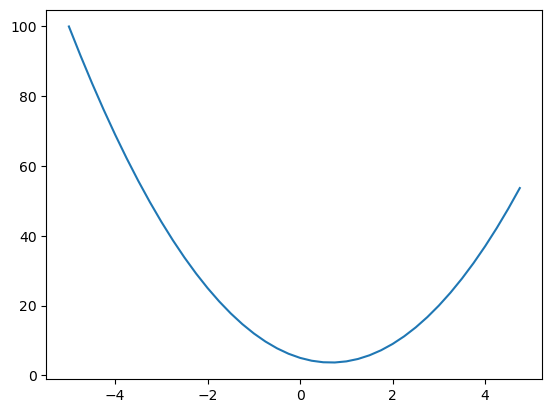

In [115]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [116]:
 h = 0.0000001
x = 2/3
(f(x+h) - f(x))/h

2.9753977059954195e-07

In [117]:
a = 2.0
b=-3.0
c=10.0
d = a*b + c 
print(d)

4.0


In [118]:
h = 0.0001
#inputs
a = 2.0
b=-3.0
c=10.0
d1 = a*b + c 
c += h #differentiating with respect to c
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h) # how much the function increased by bumping the input, normalized 
                          # by h to get the slope

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
class Value:
     # takes a simple scalar value and it wraps it
    def __init__(self, data, _children=(),_op='', label=''): 
        self.data = data      #necessary dunder methods
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})" #method that returns in the class
                                          #allows for a nicer kind of method to be printed out

    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # Runs the Value class adding a and b

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad # if self and other are the same, this overrdies a value, therefore += operand is needed
        out._backward = _backward
        
        return out                          # ^ returns the children
        
    def __mul__(self, other): # have the self, not data, as it was already implemented
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data ,  (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other): # other is a int/float data type, so it does not have a data attr
        assert isinstance(other, (int, float)), "only supporting float and int powers"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += (other) * (self.data**(other-1)) * out.grad #DONT FORGET OUT.GRAD
        out._backward = _backward
        return out 
        
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
        
    def __rmul__(self, other): # other * self:
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        return out

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward 
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [120]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [324]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data=-2.0)

In [8]:
# #review #1
# class Value:
#     def __init__(self, data, _children = (), _op=''):
#         self.data = data
#         self._prev = set(_children)
#         self._op = _op
#     def __repr__(self): #no longer need data, just need self (self.data=data)
#         return f"data:({self.data})"
#     def __add__(self, other):
#         out = Value(self.data + other.data, (self, other), "+")
#         return out                           #^returns the children
# a = Value(-3)
# b = Value(1)
# a+b

In [11]:
from graphviz import Digraph
from micrograd.engine import Value
def trace(root):
    #builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

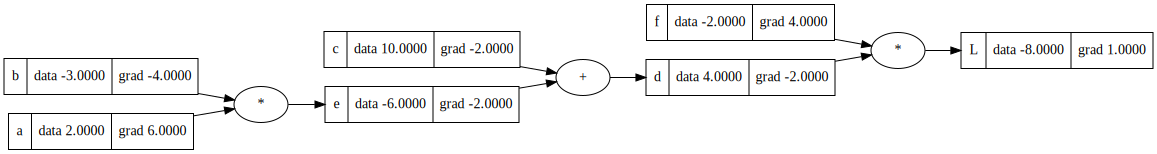

In [168]:
L.grad = 1
f.grad = 4.0
d.grad = -2
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4
draw_dot(L)
# L = d * f 
# dL/dd = f

# dd/dc ?
# dd/de = 1.0
# d = c + e dd/dc = 1.0
# chain rule in calculus: h'(x) = f'(g(x))g'(x) OR dz/dx = dz/dy * dy/dx
# The plus operand basically routes the derivative
# WANT: dL / dc = -2 * 1 = -2 KNOW: dL / dd , dd/dc 

#Dl/de = -2
# dL/da = dL/de * de/da = 6


In [ ]:
draw_dot(L)

In [169]:
a.data += 0.01 * a.grad 
b.data += 0.01 * a.grad 
c.data += 0.01 * a.grad 
f.data += 0.01 * a.grad 

e = a * b 
d = e + c
L = d * f

print(L.data)


-7.766984000000001


In [333]:
# gradient test, numerical gradient: testing it
def lol():
    h = 0.001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0 + h, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-1.9999999999988916


In [ ]:
# In summary backpropogration is a recursive application of the chain rules backwards through the 
# computational graph

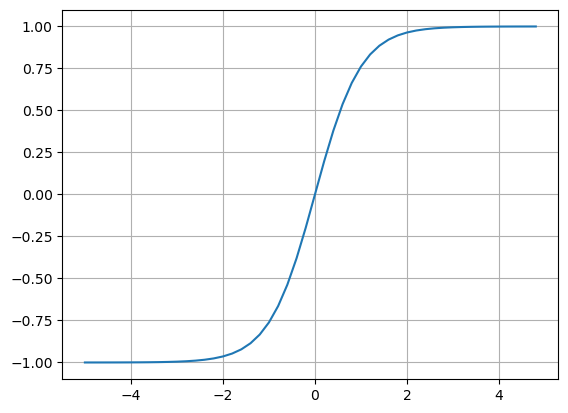

In [175]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [9]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2 
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.88131735870195432, label = 'b')
# x1*w1 + x2*w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o._backward()
draw_dot(o)

TypeError: Value.__init__() got an unexpected keyword argument 'label'

In [266]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x2w2._backward()
x1w1._backward()

In [259]:
# o.grad = 1.0
# n.grad = 0.5
# b.grad = 0.5  # derivative times 1 
# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2 

In [264]:
x1w1x2w2._backward()

In [269]:
# topological sort: laying out a graph so the edges go from left to right
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.8813173587019545),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813173587019545),
 Value(data=0.7070786659099356)]

In [278]:
o.backward()

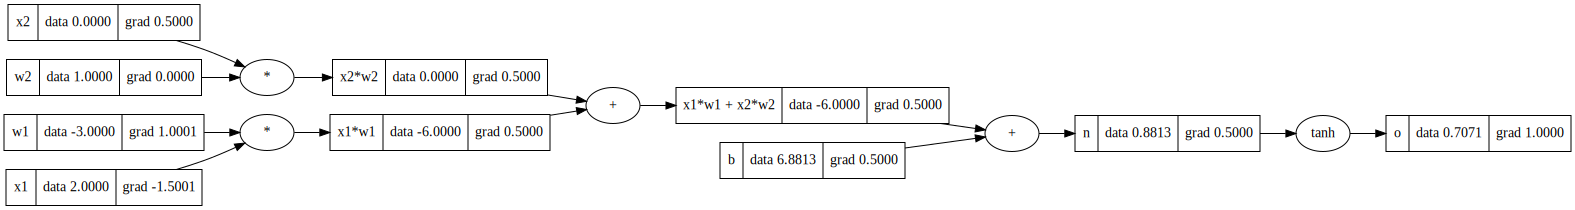

In [283]:
draw_dot(o)

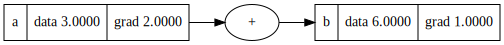

In [284]:
#bad bug
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [12]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2 
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.88131735870195432, label = 'b')
# x1*w1 + x2*w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o._backward()
draw_dot(o)

TypeError: Value.__init__() got an unexpected keyword argument 'label'

In [23]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) #call a .item() and it takes a simple tensor and it returns the element, stripping the tensor from it
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# tensors are just n dimensional arrays of scalars

torch.Tensor([2.0]).double().dtype

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


torch.float64

In [24]:
o.data.item()

0.7071066904050358

In [70]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        #takes two iterators and it creates a new iterator that iterates over the touples of the entries
        out = act.tanh()
        return out

class Layer: #list of neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x) 

Value(data=0.6758301723032691)

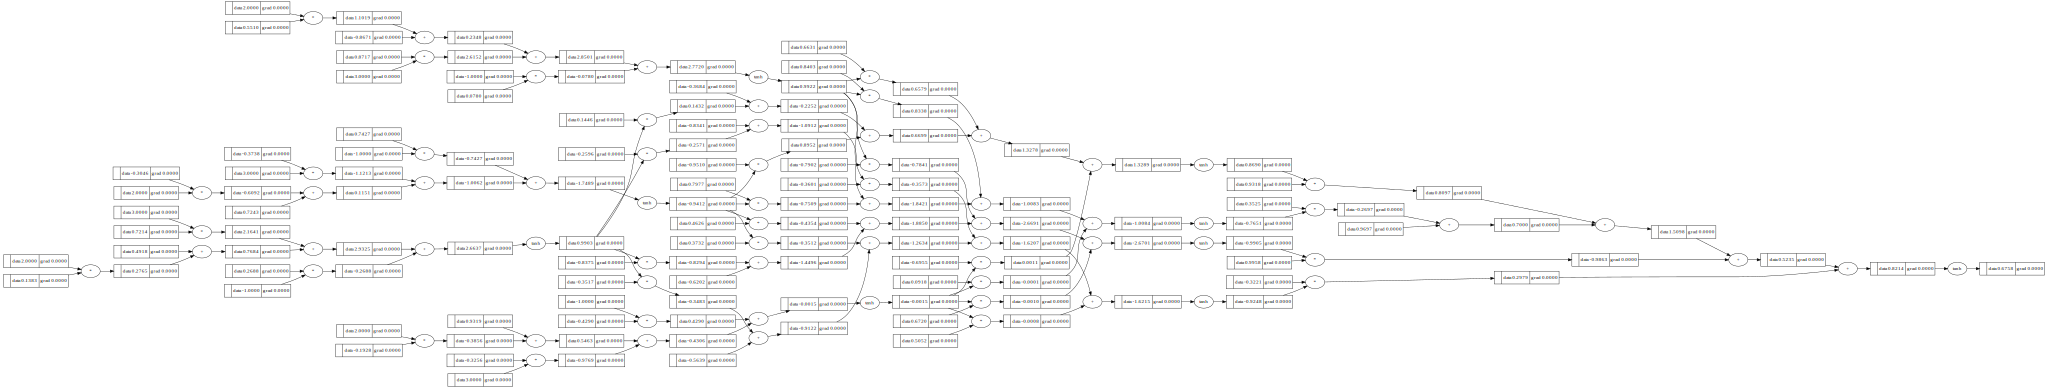

In [71]:
draw_dot(n(x))